In [1]:
import numpy as np
import copy
import pickle

from scipy import ndimage
from BaselineRemoval import BaselineRemoval
import matplotlib.pyplot as plt
import os
from scipy import interpolate
from scipy import signal
from scipy.fft import fft, ifft, fftfreq, dct, idct, dst, idst
from math import *
import timeit


plt.rcParams['figure.figsize'] = (20.0, 10.0)
# plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.rcParams['figure.dpi'] = 500
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
file_location = "../data/Raman_Mouse/corrected_4_wavenumbers/"
# file_location = "../data/Green_excitation/corrected_4_wavenumbers/"

filenames = np.load(f"{file_location}FileNames.npy")
with open(f"{'/'.join(file_location.split('/')[:-2])}/Sample_labels.pickle", 'rb') as f:
    labels = pickle.load(f)
labels = {l.split(".")[0]: val for l, val in labels.items()}

wavenumbers = np.load(f"{file_location}Wavenumbers.npy")
    
data = []
for f in filenames:
    x = np.load(f"{file_location}{f.split('.')[0]}.npy")
    data.append(((x.reshape(-1,x.shape[-1])).reshape(x.shape), labels[f.split(".")[0]]))

In [5]:
def gaussian(x, mu, sigma, scale):
    x = scale * np.exp(-0.5* ((x - mu) / sigma)**2)
    return x 

# def remove_noise_fft(x):
#     x_ = copy.copy(x)
#     mean = np.mean(x)
#     x_ -= mean
#     fourier = fft(x_)
#     xf = fftfreq(x_.shape[0], wavenumbers[1]-wavenumbers[0])
#     space = range(x_.shape[0])
#     index = np.argsort(xf)
#     fourier_real = np.real(fourier)
#     fourier_imag = np.imag(fourier)   
#     fourier_imag = fourier_imag[index]
#     fourier_real = fourier_real[index]
    
#     min_HWHM = 7
#     k = (wavenumbers[-1] - wavenumbers[0]) / (2*min_HWHM)
#     cut_off = int(x.shape[0] / 2 - k)
    
#     left, right = cut_off, x_.shape[0]-cut_off
#     smooth_fourier_imag = copy.copy(fourier_imag)
#     smooth_fourier_real = copy.copy(fourier_real)

#     func = interpolate.UnivariateSpline(space, fourier_real, k=4, s=5e9)
#     smooth_fourier_real[:left] = func(space[:left])
#     smooth_fourier_real[right:] = func(space[right:])
    
#     func = interpolate.UnivariateSpline(space, fourier_imag, k=4, s=1e9)
#     smooth_fourier_imag[:left] = func(space[:left])
#     smooth_fourier_imag[right:] = func(space[right:])
    
#     smooth_fourier = smooth_fourier_real[index] + 1j * smooth_fourier_imag[index]
    
#     return ifft(smooth_fourier) + mean

def split_signal(x):
    x = img[0].reshape(-1, img[0].shape[-1])
    n = np.random.randint(x.shape[0])
    n = 85
            
    x_ = copy.copy(x[n])
    x_ -= np.mean(x_)

#     xf = fftfreq(x_.shape[0], wavenumbers[1]-wavenumbers[0])
    space = range(x_.shape[0])
#     index = np.argsort(xf)
    
    min_HWHM = 10
    p = 200
    k = int((wavenumbers[-1] - wavenumbers[0]) / (2*min_HWHM))
    k_padding = int((wavenumbers[-1] - wavenumbers[0]) * (x_.shape[0] + 2*p) / (2*min_HWHM*x_.shape[0]))
    k_discreet = int((wavenumbers[-1] - wavenumbers[0]) / (min_HWHM))

    new_x_ = np.concatenate((x_, x_[::-1]))
    new_fourier = fft(new_x_)
    new_fourier[k*2:-k*2] = 0
    new_x = ifft(new_fourier)[:x_.shape[0]]
    
    plt.plot(ifft(new_fourier))
    plt.show()

            
    padded_x_ = np.concatenate((np.ones(p)*x_[0], x_, np.ones(p) * x_[-1]))
    padded_fourier = fft(padded_x_)
    padded_fourier.real[k_padding:-k_padding] = np.mean(padded_fourier.real[k_padding:-k_padding])
    space2 = range(2*p+x_.shape[0]) 
    func = interpolate.UnivariateSpline(space2, padded_fourier.imag, k=4, s=1e9)
    padded_fourier.imag[k_padding:-k_padding] = func(space2[k_padding:-k_padding])
    padded_x = ifft(padded_fourier)[p:-p]
        
    fourier = fft(x_)    
    fourier_real = np.real(fourier)
    fourier_imag = np.imag(fourier)
    fourier_imag = fourier_imag
    fourier_real = fourier_real
    smooth_fourier_imag = copy.copy(fourier_imag)
    smooth_fourier_real = copy.copy(fourier_real)
    func = interpolate.UnivariateSpline(space, fourier_real, k=4, s=1e9)
    smooth_fourier_real[k:-k] = func(space[k:-k])
    func = interpolate.UnivariateSpline(space, fourier_imag, k=4, s=1e9)
    smooth_fourier_imag[k:-k] = func(space[k:-k])
    smooth_fourier = smooth_fourier_real + 1j * smooth_fourier_imag
    
    discreet = dct(x_, 2, norm='backward')
    discreet2 = copy.copy(discreet)
    discreet2[k_discreet:] = 0    
    
#     plt.plot(x_)
#     discreet_sine = dst(x_, 3, norm='backward')
#     discreet_sine[k_discreet:] = 0
#     plt.plot(idst(discreet_sine, 3, norm="backward"))
#     discreet_sine = dst(x_, 3, norm='ortho')
#     discreet_sine[k_discreet:] = 0
#     plt.plot(idst(discreet_sine, 3, norm="ortho"))
#     plt.show()
    
    plt.plot(x_, label="raw")
    plt.plot(new_x, label="periodic fourier")
    plt.legend()
    plt.show()
    
    plt.plot(x_, label="raw")
    plt.plot(padded_x, label="padded fourier")
    plt.legend()
    plt.show()
    

    plt.plot(discreet)
    plt.plot(discreet2)
    plt.show()

#     plt.plot(fourier_real, label="org real fourier")
#     plt.plot(smooth_fourier_real, label="smooth real fourier")
#     plt.yscale('log')
#     plt.legend()
#     plt.show()

#     plt.plot(fourier_imag, label="org imag fourier")
#     plt.plot(smooth_fourier_imag, label="smooth imag fourier")
#     plt.legend()
#     plt.show()
    
    plt.plot(x_, label='raw')
    plt.plot(ifft(smooth_fourier), label='smooth fourier', alpha=1)
    plt.plot(idct(discreet2, 2,  norm='backward'), label='dct', alpha=0.8)
#     plt.plot(dct(discreet2, 3,  norm='forward'), label='dct')
    plt.plot(new_x, label="periodic fourier", alpha=0.5)
    plt.plot(padded_x, label="padded fourier", alpha=0.5)
    plt.legend()
    plt.show()


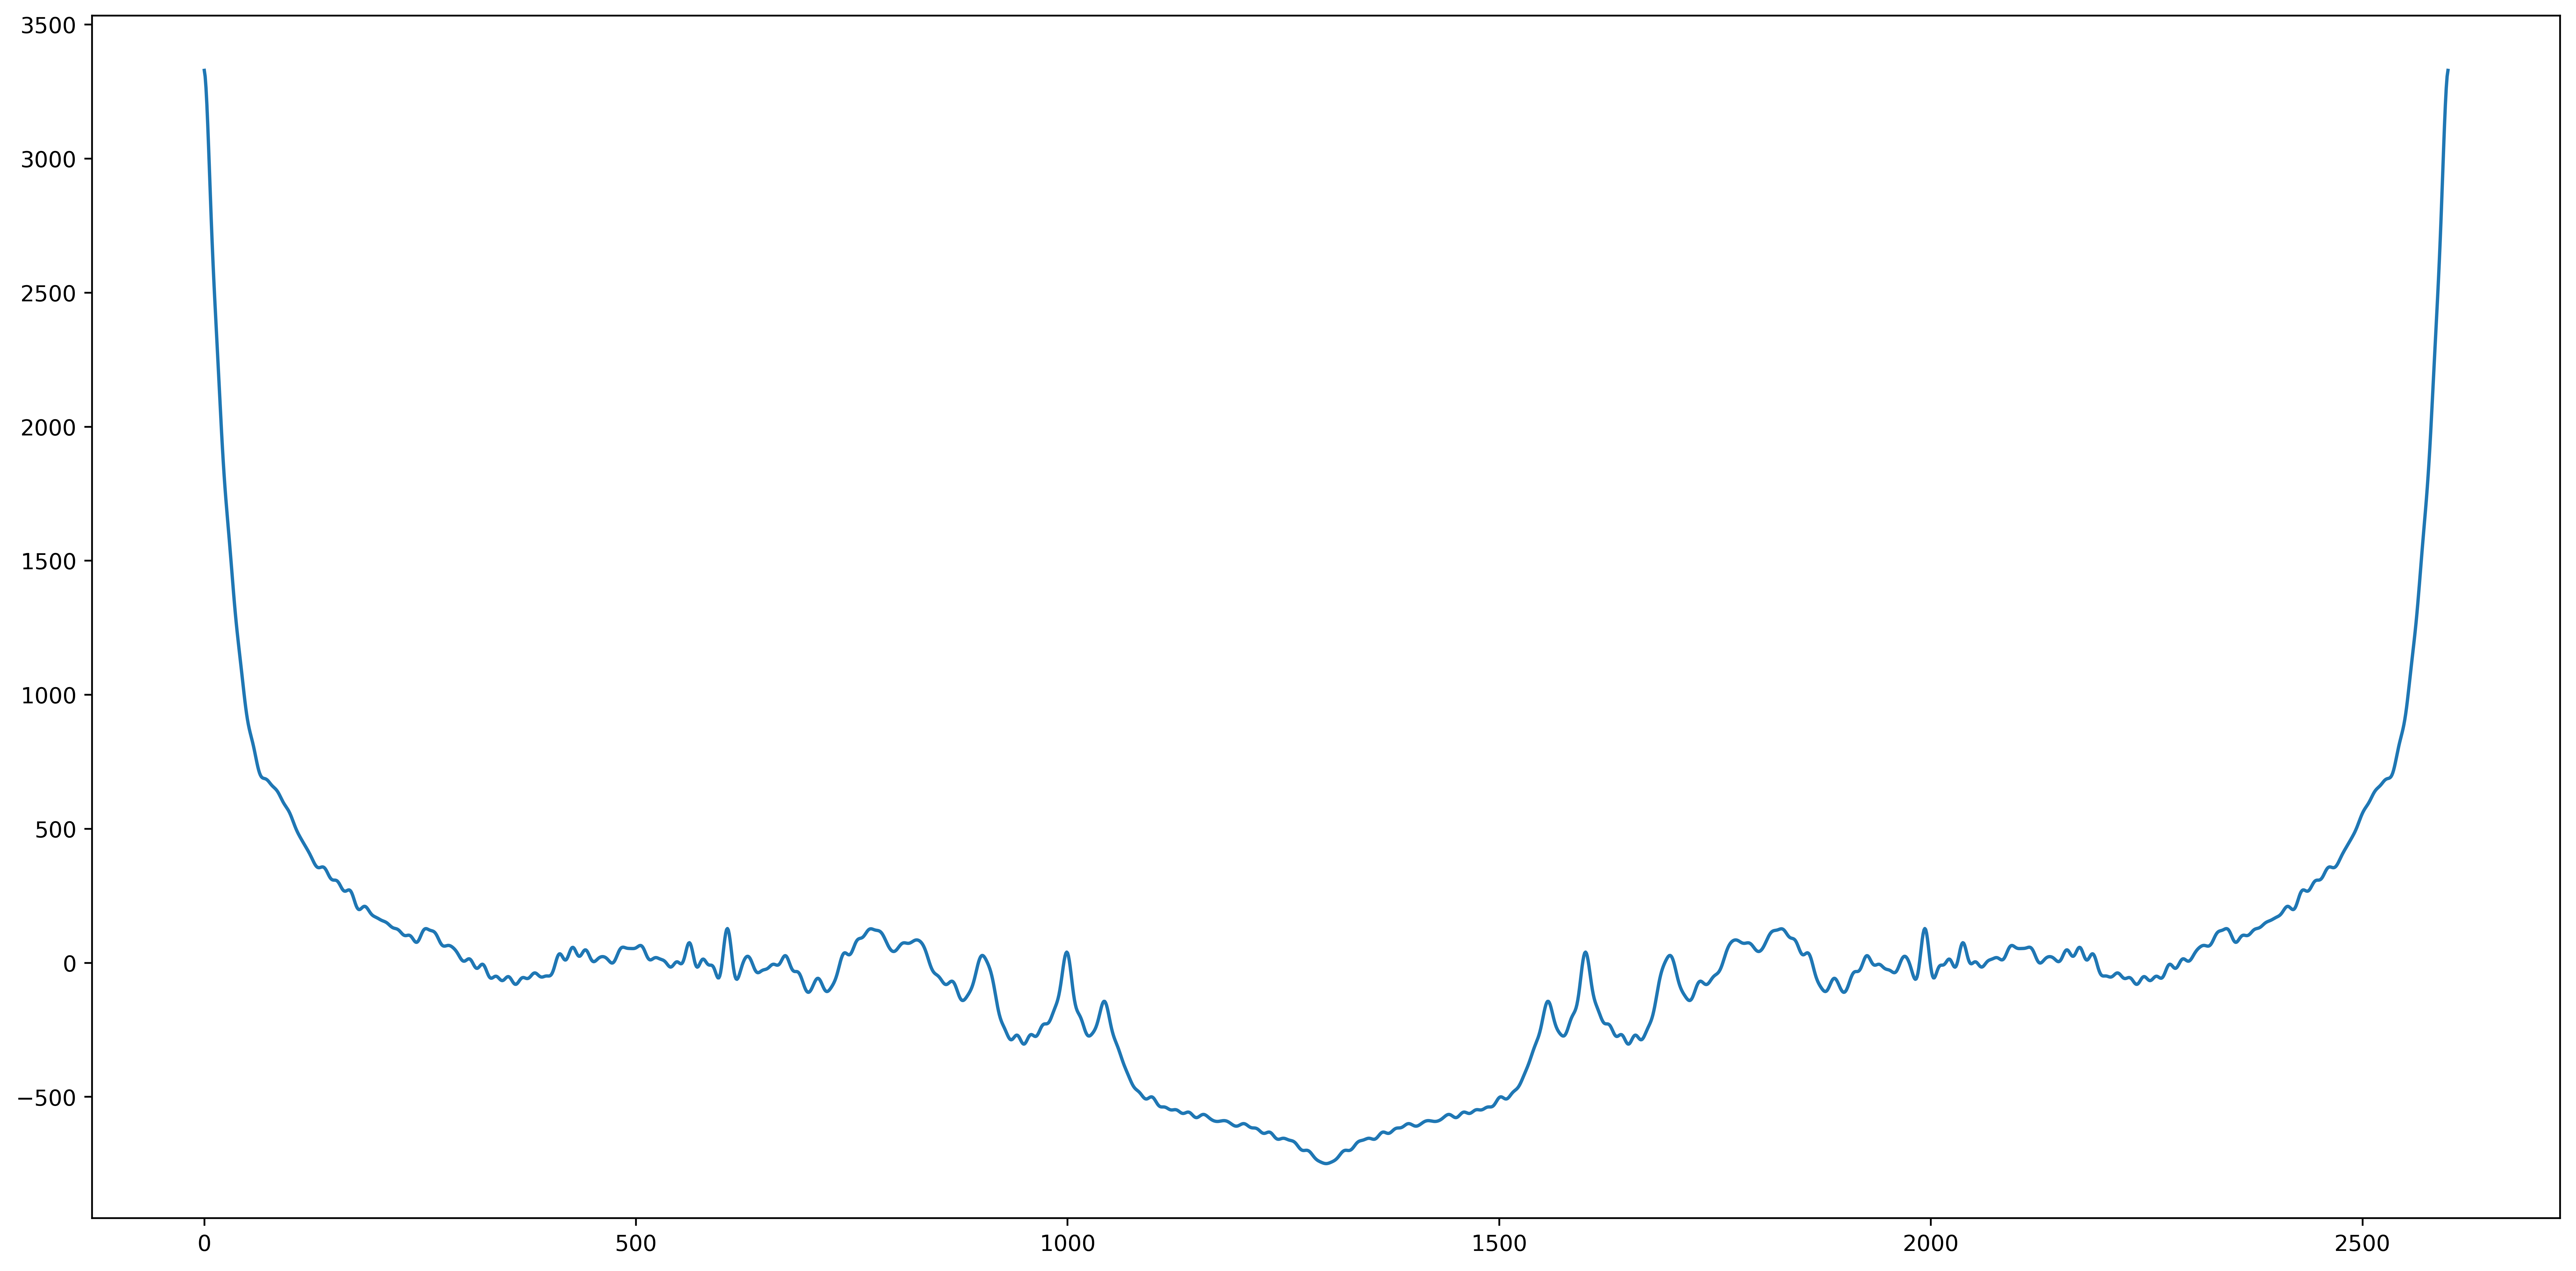

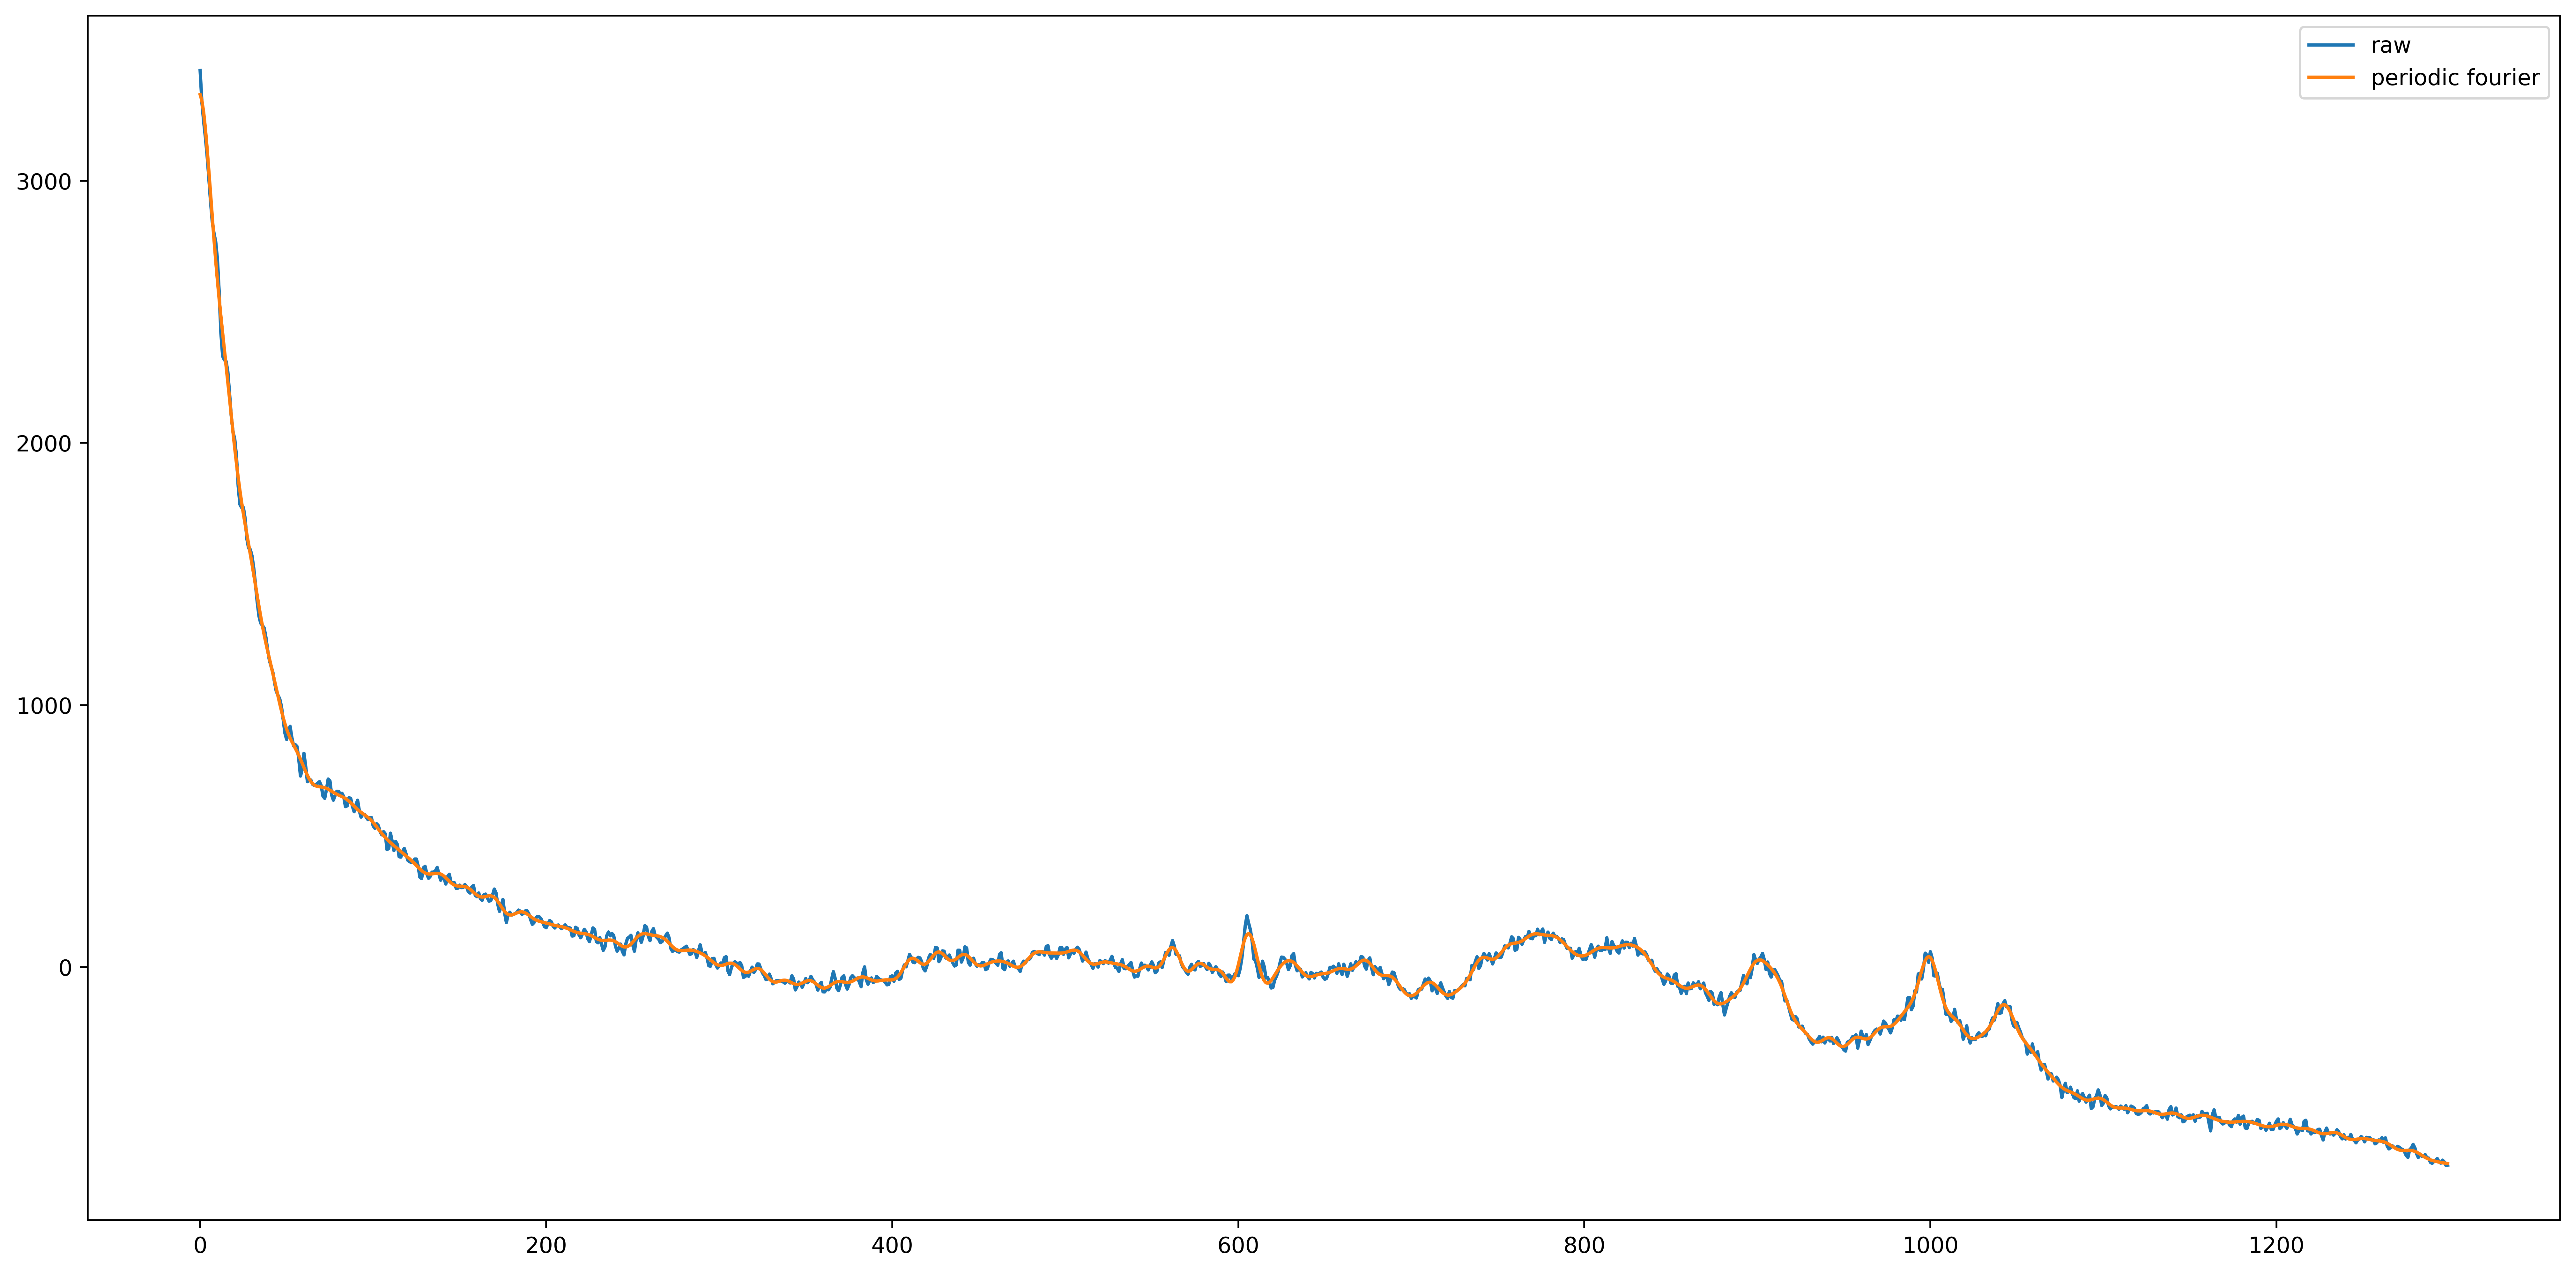

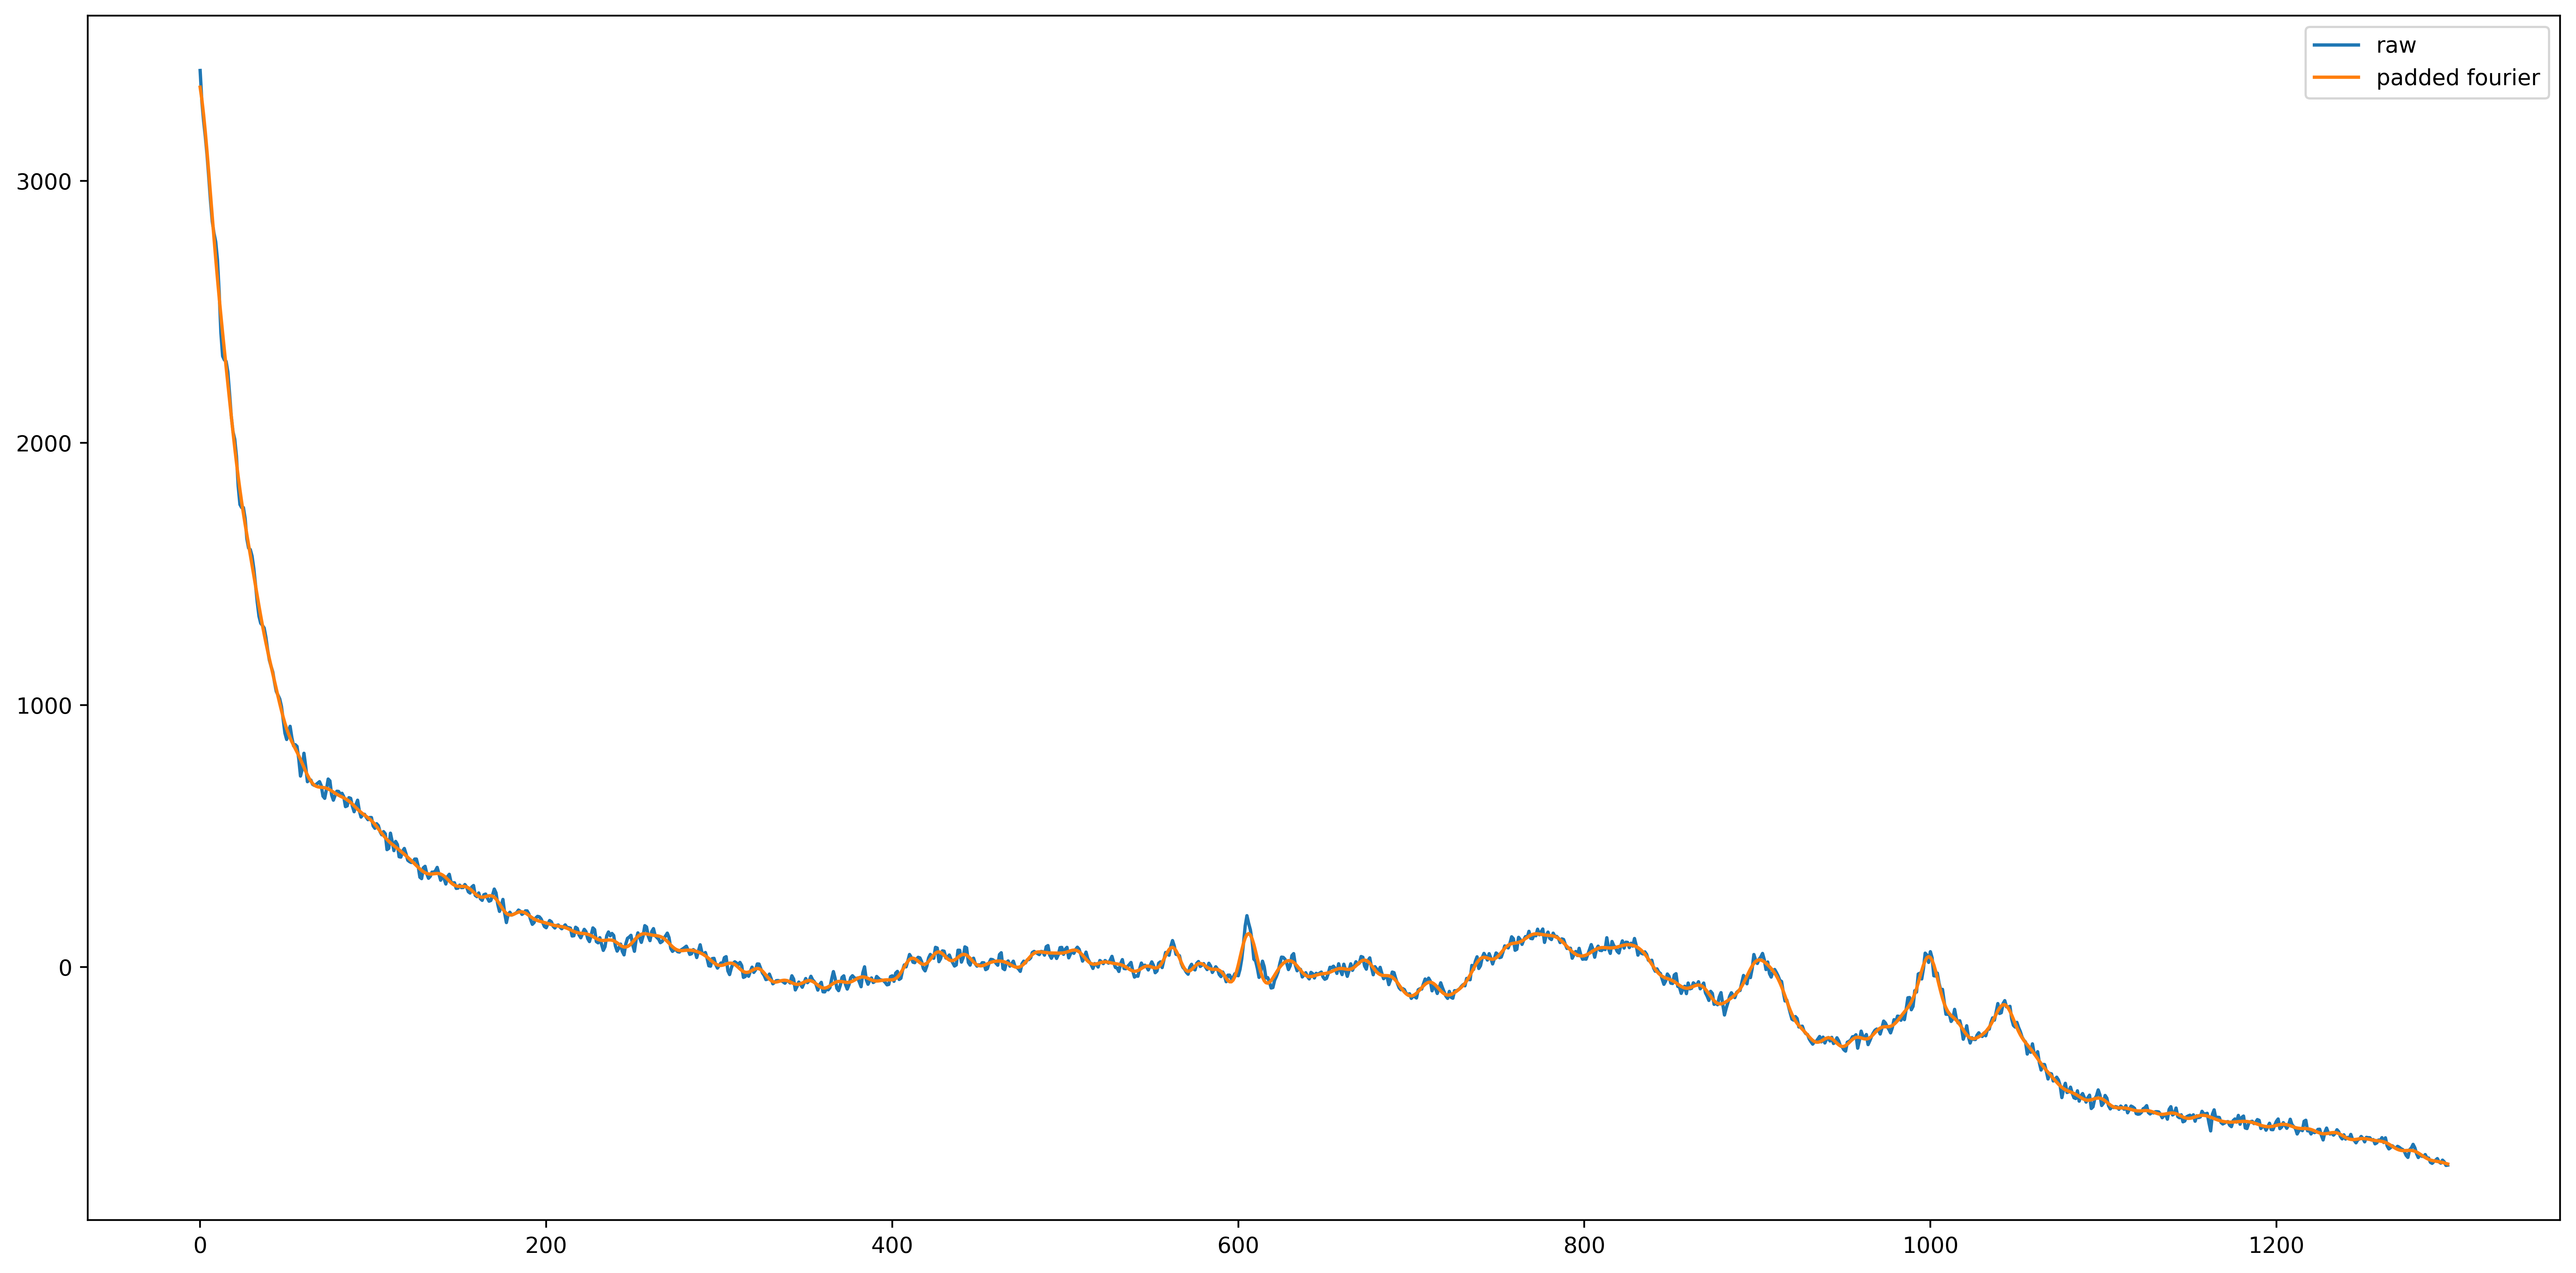

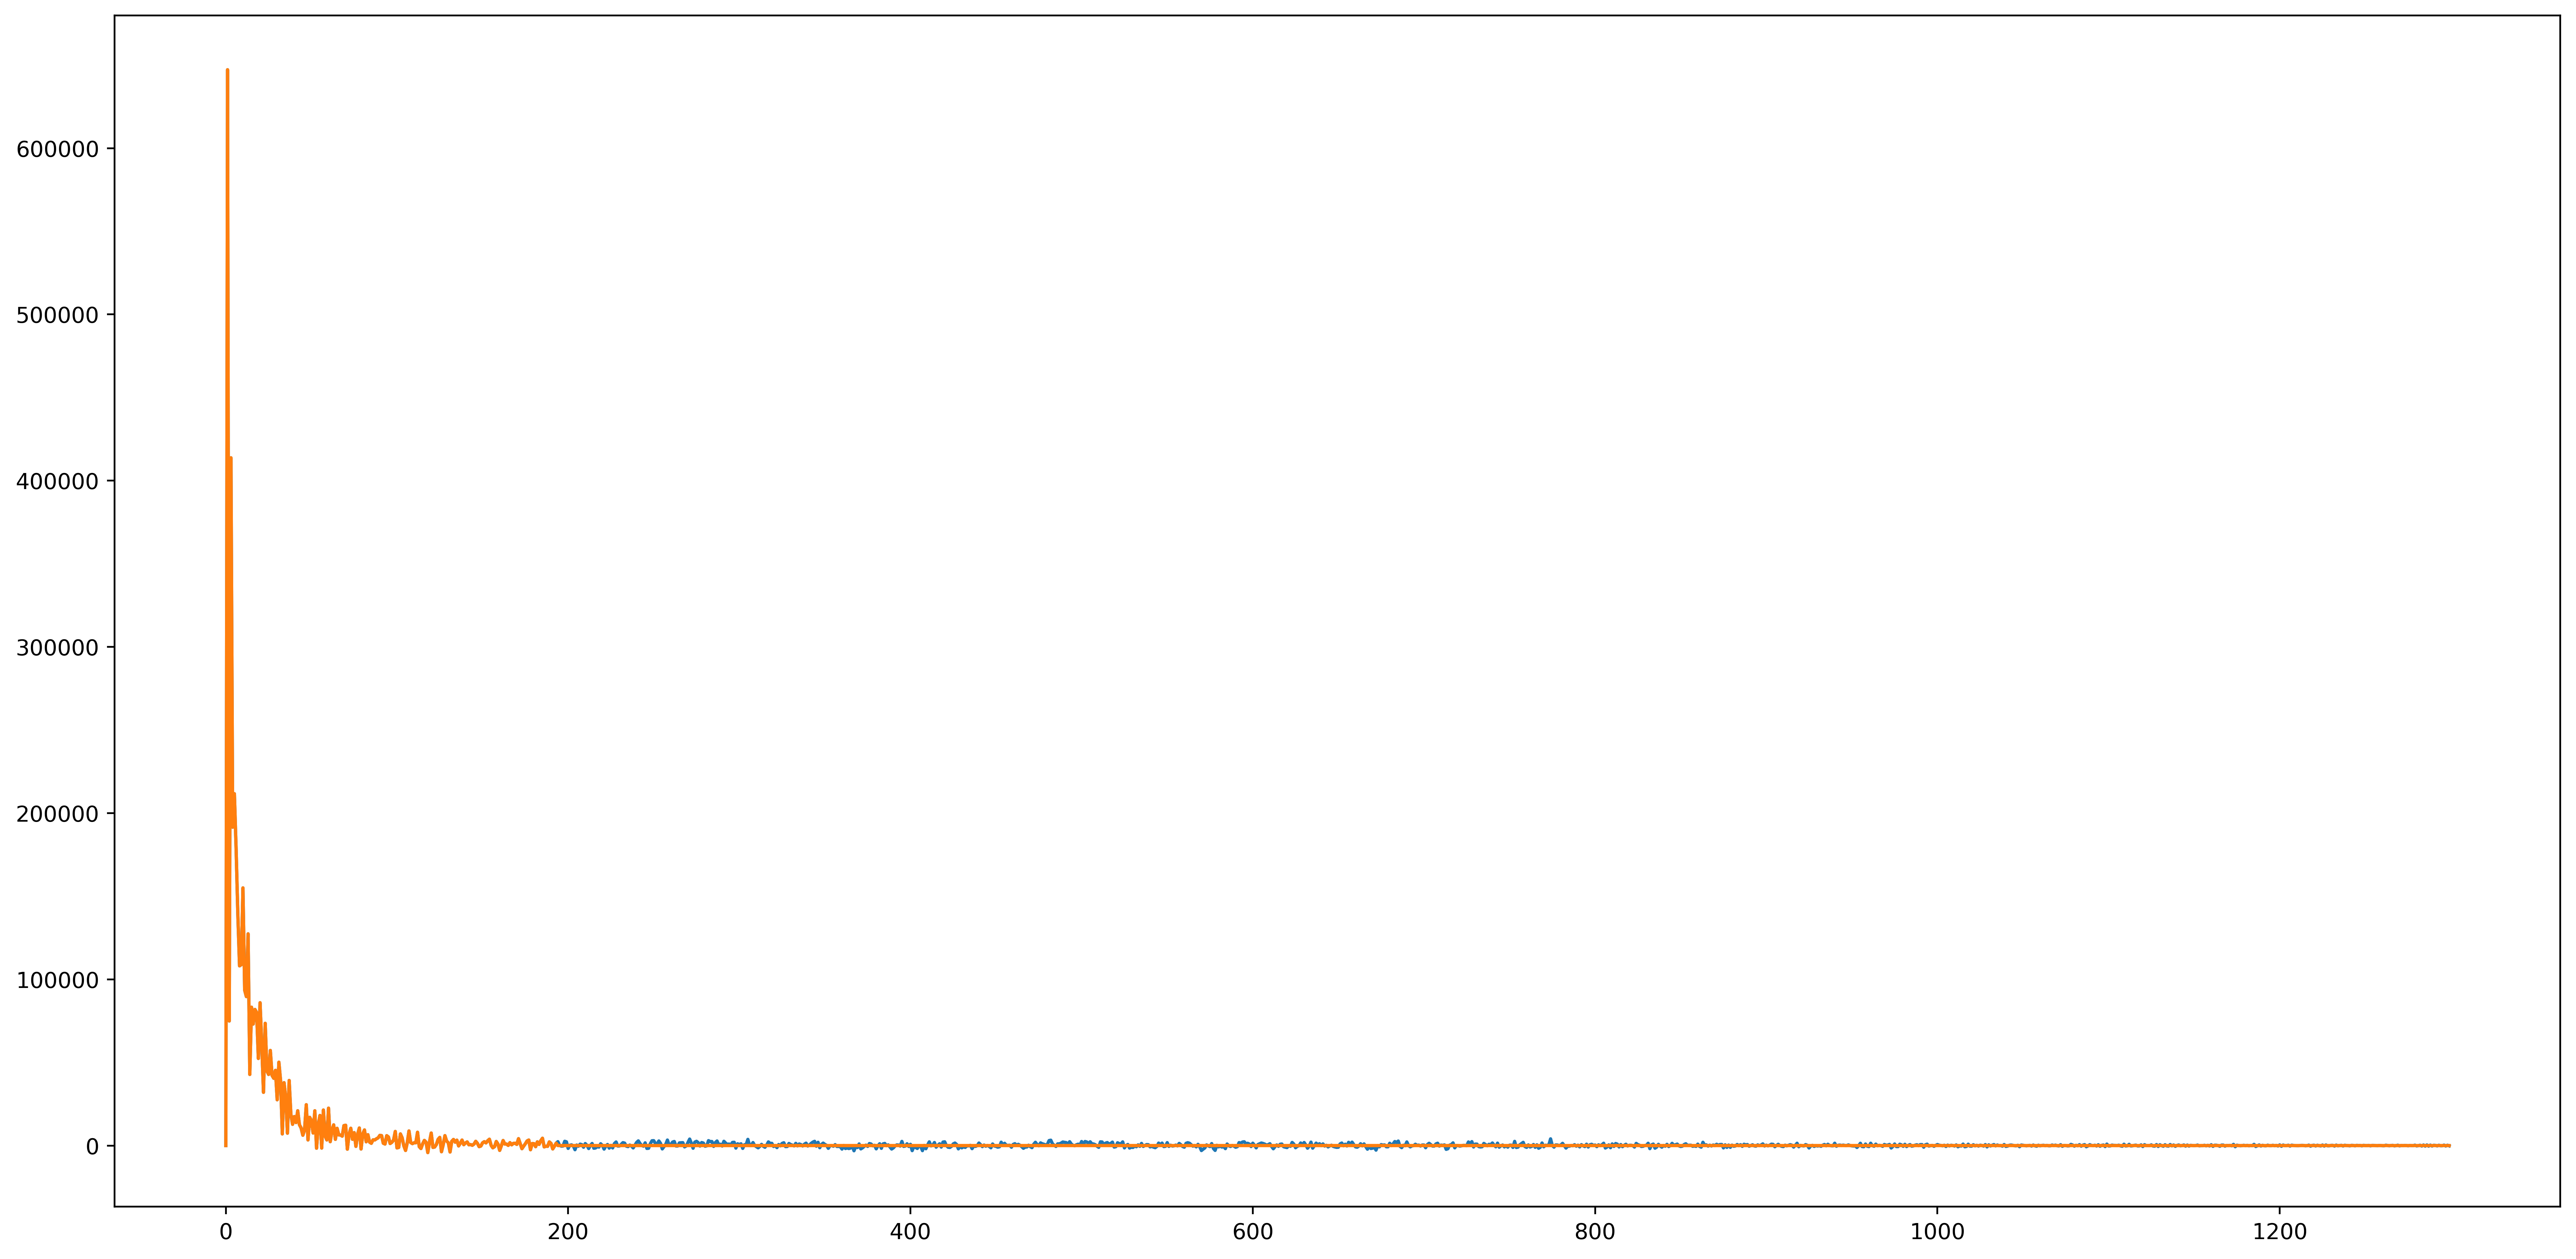

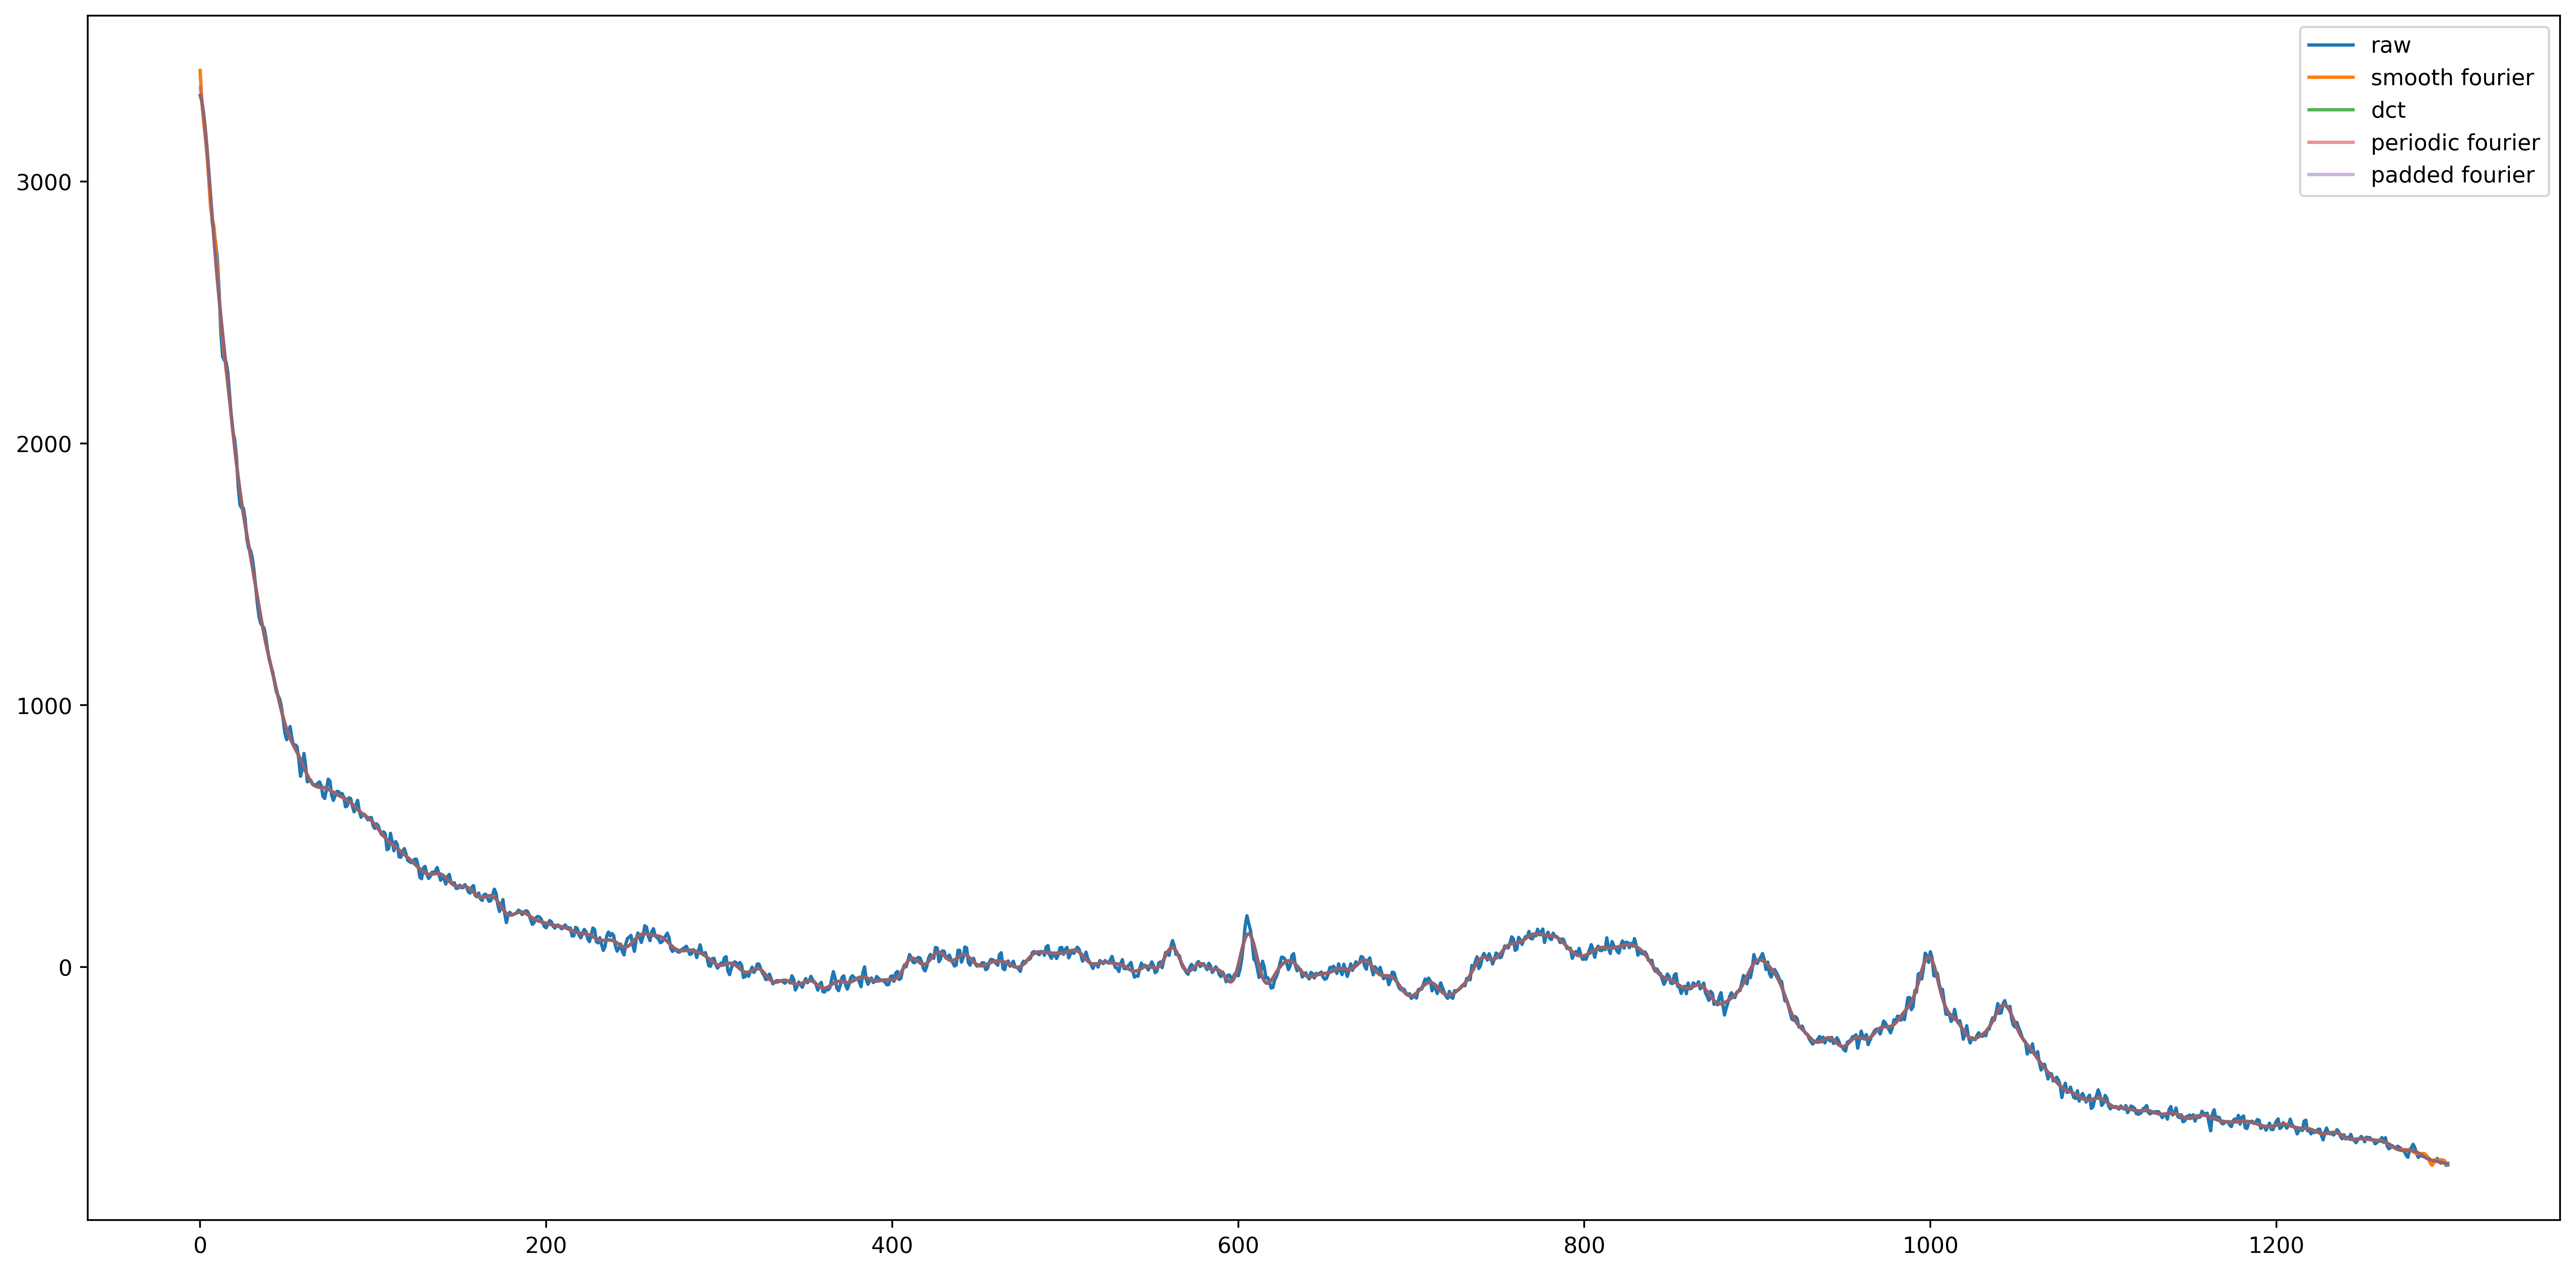

TypeError: cannot unpack non-iterable NoneType object

In [6]:
import timeit
from os import path

file_location2 = f"{'/'.join(file_location.split('/')[:-2])}/approximated/"
os.makedirs(file_location2, exist_ok=True)

shape = data[0][0].shape

for j, (f, img) in enumerate(zip(filenames, data)):   
    start = timeit.default_timer()
#     if path.exists(f'{file_location2}{f.split("/")[-1].split(".")[0]}_raman.npy'):
#         print(f'file already exist {file_location2}{f.split("/")[-1].split(".")[0]}_raman')
#         continue

#     if j < 7:
#         continue
    
    raman, photo = split_signal(img)

    stop = timeit.default_timer()
    print('Time: ', stop - start)  

    np.save(f'{file_location2}{f.split("/")[-1].split(".")[0]}_raman', raman.reshape(shape))
    np.save(f'{file_location2}{f.split("/")[-1].split(".")[0]}_photoluminescence', photo.reshape(shape))
    print(f"image: {f} is done.")

In [ ]:
# from matplotlib import colors

# def laplace_transform(x):
#     sigma = np.linspace(0.05,0.01,100)
#     time = np.arange(1300)

#     mesh = np.exp(-sigma.reshape(-1,1) * time.reshape(1,-1)) * x.reshape(1,-1)
#     laplace = fft(mesh)

#     xf = fftfreq(x.shape[0], wavenumbers[1]-wavenumbers[0])
#     space = range(x.shape[0])
#     index = np.argsort(xf)
    
#     laplace = laplace[:,index]

# #     plt.plot(laplace[0])
# #     plt.plot(laplace[100])
# #     plt.show()

# #     plt.imshow(laplace.real, vmin=0, vmax=1e4)
# #     plt.show()

# #     plt.imshow(laplace.imag, vmin=-1e4, vmax=1e4)
# #     plt.show()

#     min_HWHM = 10
#     k = (wavenumbers[-1] - wavenumbers[0]) / (2*min_HWHM)
#     cut_off = int(x.shape[0] / 2 - k)

#     min_HWHM = 200
#     k = (wavenumbers[-1] - wavenumbers[0]) / (2*min_HWHM)    
#     cut_off2 = int(x.shape[0] / 2 - k)
# #     print(cut_off, cut_off2)
    
#     left, right = cut_off, x.shape[0]-cut_off
#     left2, right2 = cut_off2, x.shape[0]-cut_off2
#     print(left, left2, right2, right)
#     alpha = 30
#     alpha2 = 2

# #     smooth_fourier_real = copy.copy(laplace[0].real)
# #     smooth_fourier_real[:left] = laplace[alpha,:left].real
# #     smooth_fourier_real[right:] = laplace[alpha,right:].real 

# #     smooth_fourier_imag = copy.copy(laplace[0].imag) 
# #     smooth_fourier_imag[:left] = laplace[alpha,:left].imag 
# #     smooth_fourier_imag[right:] = laplace[alpha,right:].imag 
    
# #     smooth_fourier_real[left:left2] = laplace[alpha2,left:left2].real 
# #     smooth_fourier_real[right2:right] = laplace[alpha2,right2:right].real 

# #     smooth_fourier_imag[left:left2] = laplace[alpha2,left:left2].imag 
# #     smooth_fourier_imag[right2:right] = laplace[alpha2,right2:right].imag 
    
# #     smooth_fourier_real = copy.copy(laplace[0].real)
# #     smooth_fourier_real[:left] = laplace[alpha,:left].real * sum(laplace[0,:left].real) / sum(laplace[alpha,:left].real)
# #     smooth_fourier_real[right:] = laplace[alpha,right:].real * sum(laplace[0,right:].real) / sum(laplace[alpha,right:].real)

# #     smooth_fourier_imag = copy.copy(laplace[0].imag) 
# #     smooth_fourier_imag[:left] = laplace[alpha,:left].imag * sum(laplace[0,:left].imag) / sum(laplace[alpha,:left].imag)
# #     smooth_fourier_imag[right:] = laplace[alpha,right:].imag * sum(laplace[0,right:].imag) / sum(laplace[alpha,right:].imag)

# #     smooth_fourier_real[left:left2] = laplace[alpha2,left:left2].real * sum(laplace[0,left:left2].real) / sum(laplace[alpha2,left:left2].real)
# #     smooth_fourier_real[right2:right] = laplace[alpha2,right2:right].real * sum(laplace[0,right2:right].real) / sum(laplace[alpha2,right2:right].real)

# #     smooth_fourier_imag[left:left2] = laplace[alpha2,left:left2].imag * sum(laplace[0,left:left2].imag) / sum(laplace[alpha2,left:left2].imag)
# #     smooth_fourier_imag[right2:right] = laplace[alpha2,right2:right].imag * sum(laplace[0,right2:right].imag) / sum(laplace[alpha2,right2:right].imag)
    
# #     plt.plot(laplace[0].real)
# #     plt.plot(smooth_fourier_real)
# #     plt.show()
    
#     smooth_fourier_real = np.mean(laplace.real, 0)
#     smooth_fourier_imag = np.mean(laplace.imag, 0)
    
#     smooth_fourier = smooth_fourier_real[index] + 1j * smooth_fourier_imag[index]
# #     plt.plot(x)
# #     plt.plot(ifft(smooth_fourier))
# #     plt.show()
    
#     return smooth_fourier


# # def split_signal(x):
# #     x = img[0].reshape(-1, img[0].shape[-1])
# #     n = np.random.randint(x.shape[0])
# # #     n = 85
            
# #     x_ = copy.copy(x[n])
# #     x_ -= np.mean(x_)
# #     laplace_transform(x_)
# # #     fourier = fft(x_)

# # #     xf = fftfreq(x_.shape[0], wavenumbers[1]-wavenumbers[0])
# # #     space = range(x_.shape[0])
# # #     index = np.argsort(xf)
# # #     fourier_real = np.real(fourier)
# # #     fourier_imag = np.imag(fourier)
    